# 数据预处理

In [24]:
import os
import random
# batch_size=4
# data_path=r'plant-seedlings-classification'
data_path=r'/kaggle/input/plant-seedlings-classification'  #for kaggle notebook
batch_size=32
train_path=os.path.join(data_path,'train')
test_path=os.path.join(data_path,'test')

In [25]:
train_path,test_path

('/kaggle/input/plant-seedlings-classification/train',
 '/kaggle/input/plant-seedlings-classification/test')

In [26]:
def get_data_list(path,train_list_path,eval_list_path):
    
#     print("path=%s"%path)
    img_classes=os.listdir(path)

    train_list=[]
    eval_list=[]

    label=0
    cnt=0
    for img_class in img_classes:
        label_dict[str(label)]=img_class
#         print("{}:{}".format(label,img_class))

        img_class_path=os.path.join(path,img_class)
        imgs=os.listdir(img_class_path)
        for img in imgs:
            img_path=os.path.join(img_class_path,img)
            cnt+=1
            if cnt%10==0:
                eval_list.append("%s\t%s\n"%(img_path,str(label)))
#                 print("%s\t%s"%(img_path,str(label)))
            else:
                train_list.append("%s\t%s\n"%(img_path,str(label)))
#                 print("%s\t%s\n"%(img_path,str(label)))
        label+=1
    
    random.shuffle(train_list)
    with open(train_list_path,'w') as f:
        for line in train_list:
            f.write(line)
    
    with open(eval_list_path,'w') as f:
        for line in eval_list:
            f.write(line)

In [27]:
label_dict={}
get_data_list(train_path,"train_list.txt","eval_list.txt")

In [28]:
label_dict

{'0': 'Scentless Mayweed',
 '1': 'Common wheat',
 '2': 'Charlock',
 '3': 'Black-grass',
 '4': 'Sugar beet',
 '5': 'Loose Silky-bent',
 '6': 'Maize',
 '7': 'Cleavers',
 '8': 'Common Chickweed',
 '9': 'Fat Hen',
 '10': 'Small-flowered Cranesbill',
 '11': 'Shepherds Purse'}

# 定义Dataset

In [29]:
from PIL import Image 
import torch
import numpy as np
class Reader(torch.utils.data.Dataset):
    def __init__(self,path):
        super().__init__()
        
        self.img_paths=[]
        self.labels=[]
        
        with open(path,'r',encoding='utf-8') as f:
            for line in f.readlines():
                self.img_paths.append(line.strip().split('\t')[0])
                self.labels.append(int(line.strip().split('\t')[1]))

    def __getitem__(self,index):

        img_path=self.img_paths[index]
        label=self.labels[index]
        
        img=Image.open(img_path)
        if img.mode !='RGB':
            img=img.convert('RGB')
        img=img.resize((224,224),Image.BILINEAR)
        img=np.array(img).astype('float32')
        img=img.transpose((2,0,1))
        img/=255.0
        
        label=np.array([label],dtype='int64')
        return img,label
    
    def pt(self,index):
        print("路径:{}\t 标签值:{}".format(self.img_paths[index],self.labels[index]))

    def __len__(self):
        return len(self.img_paths)

In [30]:
train_dataset=Reader("train_list.txt")
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)


eval_dataset=Reader("eval_list.txt")
eval_loader=torch.utils.data.DataLoader(eval_dataset,batch_size=batch_size,shuffle=False)

In [31]:
train_dataset.pt(100)
print("训练集样本数:%i"%train_dataset.__len__())
print("测试集样本数:%i"%eval_dataset.__len__())
eval_dataset.pt(0)

路径:/kaggle/input/plant-seedlings-classification/train/Small-flowered Cranesbill/985e72cfb.png	 标签值:10
训练集样本数:4275
测试集样本数:475
路径:/kaggle/input/plant-seedlings-classification/train/Scentless Mayweed/f7bbaeed3.png	 标签值:0


In [32]:
# for data in train_loader:
#     x,y = data
#     print(x.shape)
#     print(y.shape)
#     print(y)
#     print(x)
#     break

# 配置模型

In [33]:
# H,W -> H,W  out_channels musb be 3*n
class Conv8(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv3=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels,out_channels//3,kernel_size=3) , torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels//3,out_channels//3,kernel_size=3), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels//3,out_channels//3,kernel_size=3), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels//3,out_channels//3,kernel_size=3), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU()
        )
                                        
        self.conv5=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels,out_channels//3,kernel_size=5), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels//3,out_channels//3,kernel_size=5), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU()
        )
        self.conv9=torch.nn.Sequential(
            torch.nn.Conv2d(in_channels,out_channels//3,kernel_size=9), torch.nn.BatchNorm2d(out_channels//3),torch.nn.ReLU()
        )
    def forward(self,inputs):
        x1=self.conv3(inputs)
        x2=self.conv5(inputs)
        x3=self.conv9(inputs)
        return torch.concat((x1,x2,x3),dim=1)
    

In [34]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=Conv8(3,63)  # 3*224*224->63*216*216
        self.pool1=torch.nn.MaxPool2d(kernel_size=2,stride=2) #->63*108*108
        self.conv2=Conv8(63,126) # ->63*100*100
        self.pool2=torch.nn.MaxPool2d(kernel_size=5,stride=5) #->63*20*20
        self.conv3=Conv8(126,252) # ->252*12*12
        self.pool3=torch.nn.MaxPool2d(kernel_size=4,stride=4) #->252*3*3
        
        self.fc1=torch.nn.Linear(252*3*3,256)
#         self.act1=torch.nn.Sigmoid()
        self.drop1=torch.nn.Dropout()
        
        self.fc2=torch.nn.Linear(256,64)
#         self.act2=torch.nn.Sigmoid()
        self.drop2=torch.nn.Dropout()
        
        self.fc3=torch.nn.Linear(64,12)
        
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.pool2(x)
        x=self.conv3(x)
        x=self.pool3(x)
        
        x=self.fc1(torch.reshape(x,[-1,252*3*3]))
#         x=self.act1(x)
        x=self.drop1(x)
        
        x=self.fc2(x)
#         x=self.act2(x)
        x=self.drop2(x)
        
        x=self.fc3(x)
        
        return x

In [35]:
model=CNN()
print(model)


CNN(
  (conv1): Conv8(
    (conv3): Sequential(
      (0): Conv2d(3, 21, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(21, 21, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(21, 21, kernel_size=(3, 3), stride=(1, 1))
      (7): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv2d(21, 21, kernel_size=(3, 3), stride=(1, 1))
      (10): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
    (conv5): Sequential(
      (0): Conv2d(3, 21, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(21, 21, kernel_size=(5, 5), stride=(1, 1))
      (4):

In [36]:
from sklearn.metrics import f1_score
def fit(epochs):
    device = torch.device('cuda')
    model.to(device)
    model.train()

    cross_entropy=torch.nn.CrossEntropyLoss()
    opt=torch.optim.Adam(params=model.parameters(),lr=0.0001)

    steps=0
    maxf1=0
    maxacc=0
    
    steps_list=[]
    train_losses_list=[]
    eval_losses_list=[]
    train_accs_list=[]
    eval_accs_list=[]
    train_f1_list=[]
    eval_f1_list=[] 
    
    for epo in range(epochs):
        for batch_id,data in enumerate(train_loader):
            model.train()
            opt.zero_grad()
            x=data[0].to(device)
            y=data[1].to(device)
            pred=model(x)
#             print(pred.shape,y.shape)
            loss=cross_entropy(pred,y.squeeze())
            res = torch.argmax(pred,1)
#             print(res,y.squeeze())
            acc = ((torch.eq(res,y.squeeze())).sum()).item()/res.shape[0]
#             acc=(pred==y).mean()
            f1=float(f1_score(y.cpu(),res.cpu(),average="micro"))
            loss.backward()
            opt.step()


            steps+=1
            if steps%10==0:
                print("epoch:{},step:{},loss:{},acc:{},f1:{}".format(epo,steps,loss.item(),acc,f1))
                losses=[]
                accs=[]
                model.eval()
                for eval_data in eval_loader:
                    eval_x=eval_data[0].to(device)
                    eval_y=eval_data[1].to(device)
                    eval_pred=model(eval_x)
                    eval_loss=cross_entropy(eval_pred,eval_y.squeeze())
                    eval_res=torch.argmax(eval_pred,1)
                    eval_acc=((torch.eq(eval_res,eval_y.squeeze())).sum()).item()/eval_res.shape[0]
                    losses.append(float(eval_loss))
                    accs.append(float(eval_acc))
                    
                avg_acc=sum(accs)/len(accs)    
                eval_f1=float(f1_score(eval_y.cpu(),eval_res.cpu(),average="micro"))
                print("-"*10,"[Valid]  eval_loss:{},eval_acc:{},f1:{}".format(sum(losses)/len(losses),avg_acc,eval_f1))
                    

                if maxf1<eval_f1 or (maxf1==eval_f1 and maxacc<avg_acc):
                    maxf1=eval_f1
                    maxacc=avg_acc
                    save_path='best.pd'
                    print('save to %s'%save_path)
                    torch.save(model.state_dict(),save_path)
                
                steps_list.append(steps)
                train_losses_list.append(float(loss))
                eval_losses_list.append(float(sum(losses)/len(losses)))
                train_accs_list.append(float(acc))
                eval_accs_list.append(float(avg_acc))
                train_f1_list.append(f1)
                eval_f1_list.append(eval_f1)
                
        
            

        torch.save(model.state_dict(),"final.pd")
    return steps_list, train_losses_list, eval_losses_list, train_accs_list, eval_accs_list,train_f1_list,eval_f1_list

In [37]:
import warnings
warnings.filterwarnings("ignore")
steps_list, train_losses_list, eval_losses_list, train_accs_list, eval_accs_list,train_f1_list,eval_f1_list=fit(epochs=25)

epoch:0,step:10,loss:2.4114186763763428,acc:0.125,f1:0.125
---------- [Valid]  eval_loss:2.4553735415140787,eval_acc:0.12708333333333333,f1:0.0
save to best.pd
epoch:0,step:20,loss:2.6668272018432617,acc:0.09375,f1:0.09375
---------- [Valid]  eval_loss:2.4401553948720296,eval_acc:0.12708333333333333,f1:0.0
epoch:0,step:30,loss:2.5519049167633057,acc:0.21875,f1:0.21875
---------- [Valid]  eval_loss:2.440800587336222,eval_acc:0.11041666666666666,f1:0.0
epoch:0,step:40,loss:2.071718215942383,acc:0.34375,f1:0.34375
---------- [Valid]  eval_loss:2.438752563794454,eval_acc:0.16666666666666666,f1:0.0
save to best.pd
epoch:0,step:50,loss:2.009575843811035,acc:0.375,f1:0.375
---------- [Valid]  eval_loss:2.2249367952346804,eval_acc:0.20833333333333334,f1:0.0
save to best.pd
epoch:0,step:60,loss:1.6909146308898926,acc:0.46875,f1:0.46875
---------- [Valid]  eval_loss:1.9421615123748779,eval_acc:0.36666666666666664,f1:0.0
save to best.pd
epoch:0,step:70,loss:2.067708730697632,acc:0.34375,f1:0.3437

# 实验结果分析(绘图)

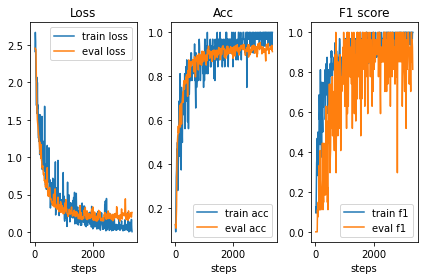

In [43]:
import matplotlib.pyplot as plt
plt.subplot(131)
plt.title("Loss")
plt.xlabel("steps")
# plt.ylabel("loss")
plt.plot(steps_list,train_losses_list)
plt.plot(steps_list,eval_losses_list)
plt.legend(["train loss","eval loss"])

plt.subplot(132)
plt.title("Acc")
plt.xlabel("steps")
# plt.ylabel("acc")
plt.plot(steps_list,train_accs_list)
plt.plot(steps_list,eval_accs_list)
plt.legend(["train acc","eval acc"])

plt.subplot(133)
plt.title("F1 score")
plt.xlabel("steps")
plt.plot(steps_list,train_f1_list)
plt.plot(steps_list,eval_f1_list)
plt.legend(["train f1","eval f1"])

plt.tight_layout()


# 保存模型

In [39]:
torch.save(model.state_dict(),"final.pd")

# 加载模型

In [55]:
state_path='final.pd'


model=CNN()
model.load_state_dict(torch.load(state_path))

<All keys matched successfully>

# 预测

In [56]:
def get_test_list(path,test_list_path):
    
    imgs=os.listdir(path)
    test_list=[]

    for img in imgs:
        img_path=os.path.join(path,img)
        test_list.append(img_path+"\n")
#         print(img_path)
    with open(test_list_path,'w') as f:
        for line in test_list:
            f.write(line)
            
            



from PIL import Image 
import torch
import numpy as np
class Test_Reader(torch.utils.data.Dataset):
    def __init__(self,path):
        super().__init__()
        
        self.img_paths=[]
        
        with open(path,'r',encoding='utf-8') as f:
            for line in f.readlines():
                self.img_paths.append(line.strip())
        self.img_paths.sort()

    def __getitem__(self,index):

        img_path=self.img_paths[index]
        
        img=Image.open(img_path)
        if img.mode !='RGB':
            img=img.convert('RGB')
        img=img.resize((224,224),Image.BILINEAR)
        img=np.array(img).astype('float32')
        img=img.transpose((2,0,1))
        img/=255.0
        
        return img,img_path


    def __len__(self):
        return len(self.img_paths)

get_test_list(test_path,"test_list.txt")
test_dataset=Test_Reader("test_list.txt")
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

device = torch.device('cuda')
with open('submit.csv','w') as f:
    f.write("file,species\n")
    

model.to(device)
model.eval()

for test_data in test_loader:
    test_x=test_data[0].to(device)
    img_path=test_data[1][0]
    test_pred=model(test_x)
    test_res=torch.argmax(test_pred,1)
#     print(type(test_res.item()),type(img_path),test_res.item(),img_path.strip().split(r'/')[-1])
    with open('submit.csv','a') as f:
        f.write(img_path.strip().split(r'/')[-1]+","+label_dict[str(test_res.item())]+"\n")

In [54]:
import os
os.chdir('/kaggle/working')
print(os.getcwd())
print(os.listdir("/kaggle/working"))
from IPython.display import FileLink
FileLink('final.pd')

/kaggle/working
['submit.csv', '.virtual_documents', 'train_list.txt', '__notebook_source__.ipynb', 'eval_list.txt', 'best.pd', 'test_list.txt', 'final.pd']


/kaggle/working/final.pd